# Zero-shot Quantification

In [1]:
# ==========================================================
# Compute Dice metrics for ZERO-SHOT predictions only
# ==========================================================

from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage import label as cc_label

# ----------------------------
# Paths
# ----------------------------

ZEROSHOT_ROOT = Path(
    "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot"
)

GT_ROOT = Path(
    "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
)

ZEROSHOT_MODELS = ["clip_text", "clip_notext", "imgonly", "random"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)
PROB_THRESHOLD = 0.5


# ----------------------------
# Metric definitions (UNCHANGED)
# ----------------------------

def binary_dice(pred, gt, eps=1e-8):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2 * inter + eps) / (pred.sum() + gt.sum() + eps)

def background_dice(pred, gt, eps=1e-8):
    pred_bg = ~pred
    gt_bg = ~gt
    inter = np.logical_and(pred_bg, gt_bg).sum()
    return (2 * inter + eps) / (pred_bg.sum() + gt_bg.sum() + eps)

def total_dice(pred, gt):
    return 0.5 * (binary_dice(pred, gt) + background_dice(pred, gt))

def foreground_dice(pred, gt, eps=1e-8):
    fg_union = np.logical_or(pred, gt)
    if fg_union.sum() == 0:
        return 1.0
    p = pred[fg_union]
    g = gt[fg_union]
    inter = np.logical_and(p, g).sum()
    return (2 * inter + eps) / (p.sum() + g.sum() + eps)

def count_instances(mask):
    if mask.sum() == 0:
        return 0
    _, n = cc_label(mask.astype(bool), structure=STRUCT_3D_26)
    return n


# ----------------------------
# Compute metrics
# ----------------------------

rows = []

for model in ZEROSHOT_MODELS:

    for data_type, gt_sub in DATA_TYPE_TO_GT_SUBDIR.items():

        pred_dir = ZEROSHOT_ROOT / f'{data_type}_patches' / model / "preds"
        gt_dir = GT_ROOT / gt_sub

        if not pred_dir.exists():
            continue

        for prob_path in pred_dir.glob("*_prob.nii.gz"):
            stem = prob_path.name.replace("_prob.nii.gz", "")
            gt_path = gt_dir / f"{stem}_label.nii.gz"

            if not gt_path.exists():
                continue

            pred_prob = nib.load(prob_path).get_fdata().astype(np.float32)
            gt_bin = nib.load(gt_path).get_fdata() > 0.5

            pred_bin = pred_prob >= PROB_THRESHOLD

            td = total_dice(pred_bin, gt_bin)
            fd = foreground_dice(pred_bin, gt_bin)

            n_pred = count_instances(pred_bin)
            n_gt = count_instances(gt_bin)
            inst_d = 1.0 if (n_pred == 0 and n_gt == 0) else (
                2 * min(n_pred, n_gt) / (n_pred + n_gt)
            )

            rows.append({
                "model": model,
                "data_type": data_type,
                "total_dice": td,
                "foreground_dice": fd,
                "instance_dice": inst_d,
            })

metrics_df_zeroshot = pd.DataFrame(rows)
print("[INFO] Zero-shot metric rows:", len(metrics_df_zeroshot))


[INFO] Zero-shot metric rows: 352


In [2]:
display(metrics_df_zeroshot)

,model,data_type,total_dice,foreground_dice,instance_dice
0,clip_text,amyloid_plaque,0.364780,0.002520,0.007989
1,clip_text,amyloid_plaque,0.398683,0.001690,0.009677
2,clip_text,amyloid_plaque,0.370114,0.003098,0.006143
3,clip_text,amyloid_plaque,0.393572,0.001185,0.005839
4,clip_text,amyloid_plaque,0.415510,0.000141,0.001505
...,...,...,...,...,...
347,random,vessels,0.508492,0.047377,0.651163
348,random,vessels,0.506109,0.070662,0.719298
349,random,vessels,0.665294,0.377072,0.243902
350,random,vessels,0.494823,0.018872,0.164948


In [3]:
# Identify numeric metric columns explicitly
metric_cols = ["total_dice", "foreground_dice", "instance_dice"]

summary_table = (
    metrics_df_zeroshot
    .groupby(["model", "data_type"])[metric_cols]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model"])
)

# Display nicely (only format numeric columns)
try:
    display(summary_table.style.format({c: "{:.4f}" for c in metric_cols}))
except NameError:
    print(summary_table)


,model,data_type,total_dice,foreground_dice,instance_dice
0,clip_notext,amyloid_plaque,0.4973,0.0124,0.1189
4,clip_text,amyloid_plaque,0.3927,0.0044,0.0105
8,imgonly,amyloid_plaque,0.5001,0.0062,0.0698
12,random,amyloid_plaque,0.5162,0.0389,0.1965
1,clip_notext,c_fos_positive,0.4520,0.0009,0.3634
5,clip_text,c_fos_positive,0.3425,0.0327,0.8735
9,imgonly,c_fos_positive,0.5090,0.0405,0.8097
13,random,c_fos_positive,0.5395,0.0914,0.5675
2,clip_notext,cell_nucleus,0.5003,0.0194,0.3123
6,clip_text,cell_nucleus,0.4114,0.0602,0.3194



=== amyloid_plaque_patches ===
Visualizing: patch_003_vol016_ch0


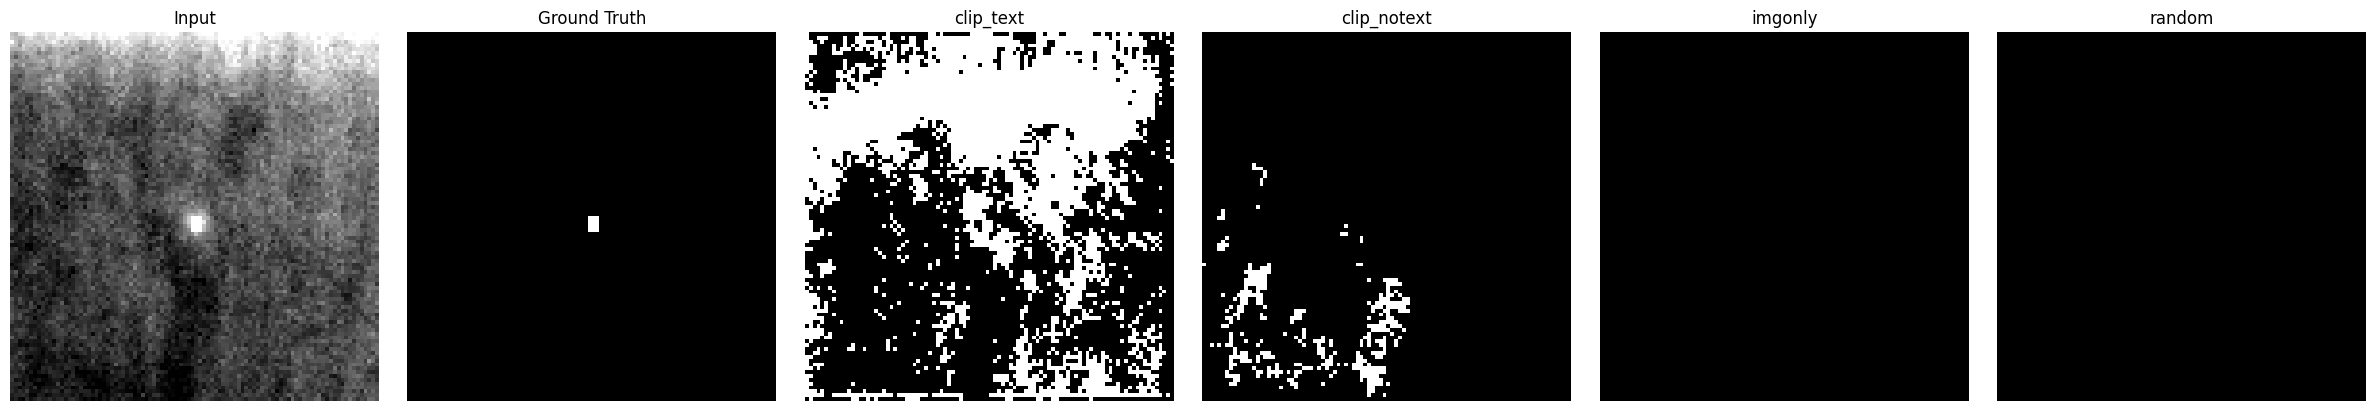

Visualizing: patch_000_vol000_ch0


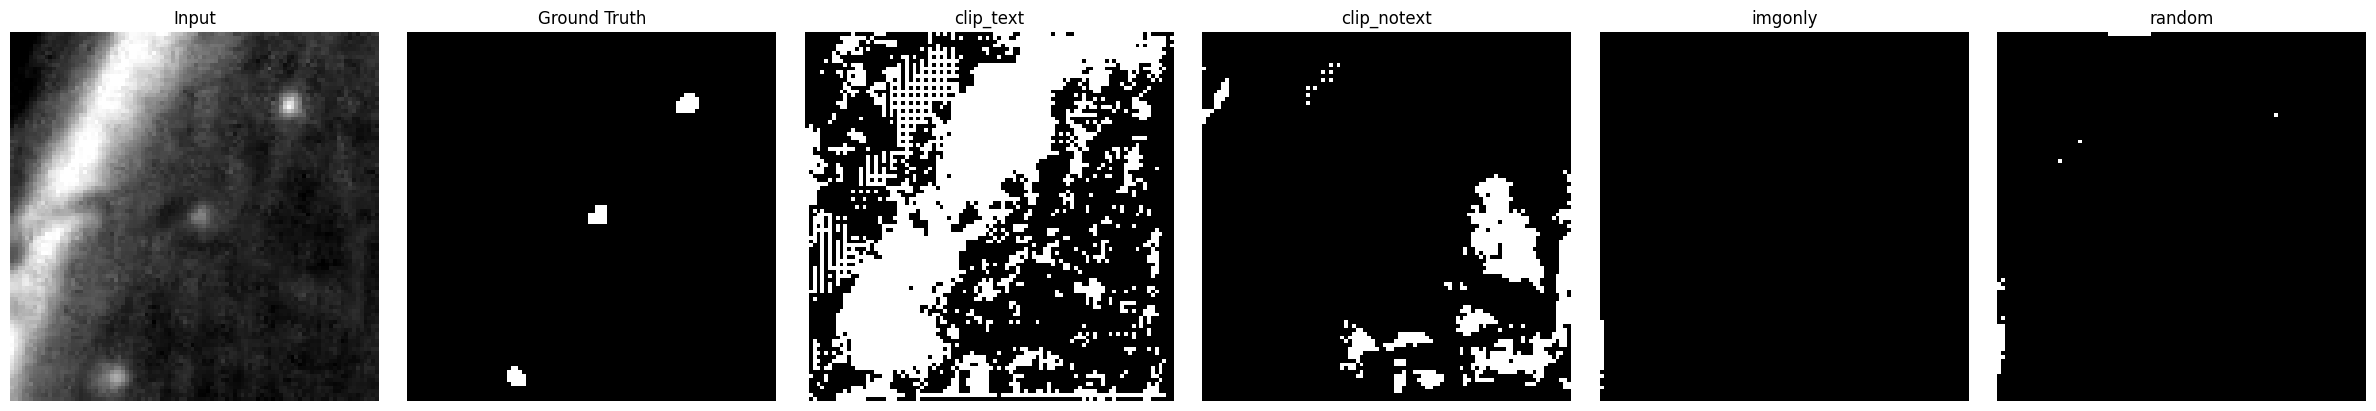


=== c_fos_positive_patches ===
Visualizing: patch_002_vol014_ch0


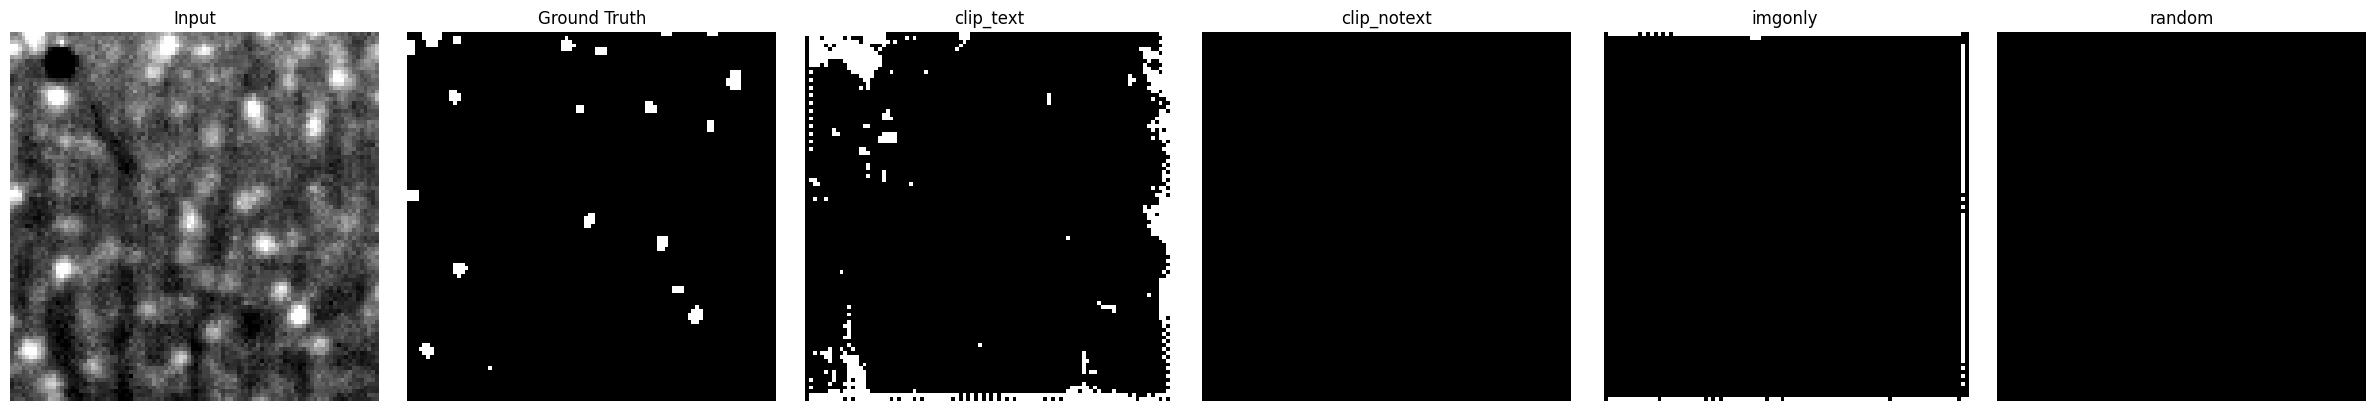

Visualizing: patch_000_vol009_ch0


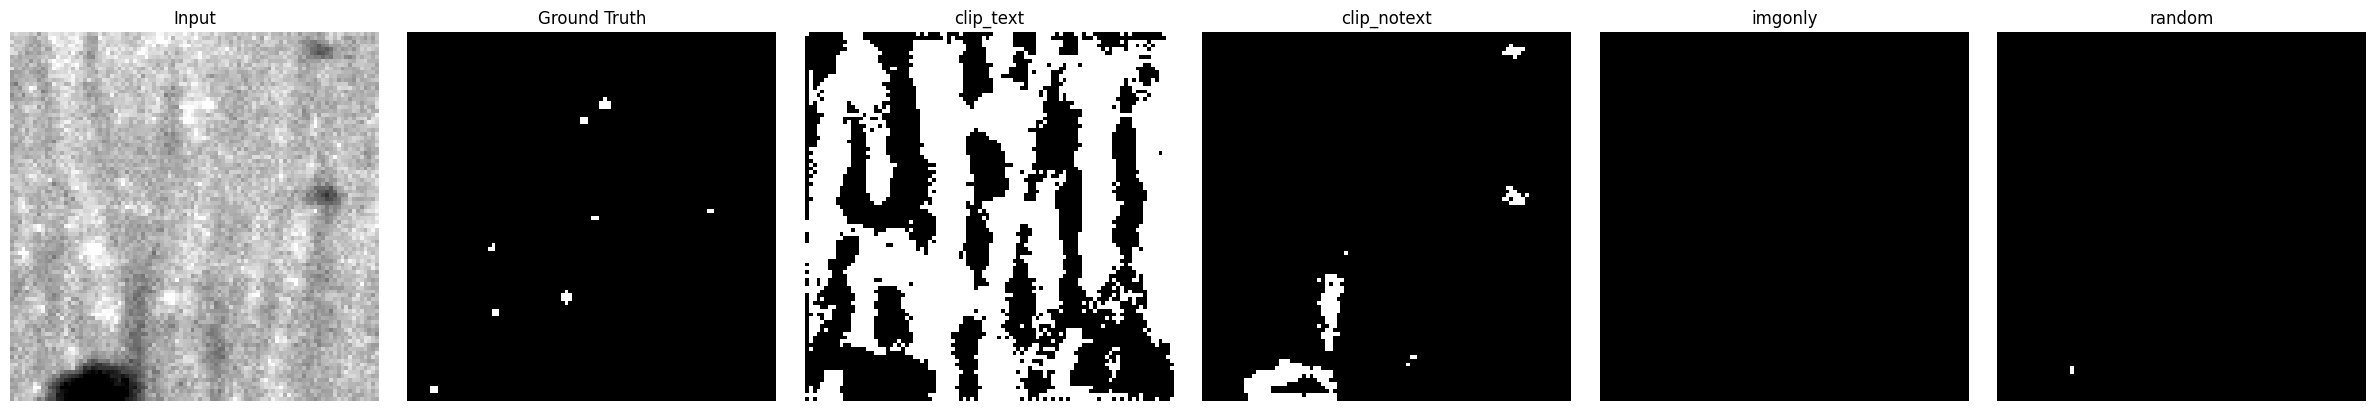


=== cell_nucleus_patches ===
Visualizing: patch_007_vol006_ch0


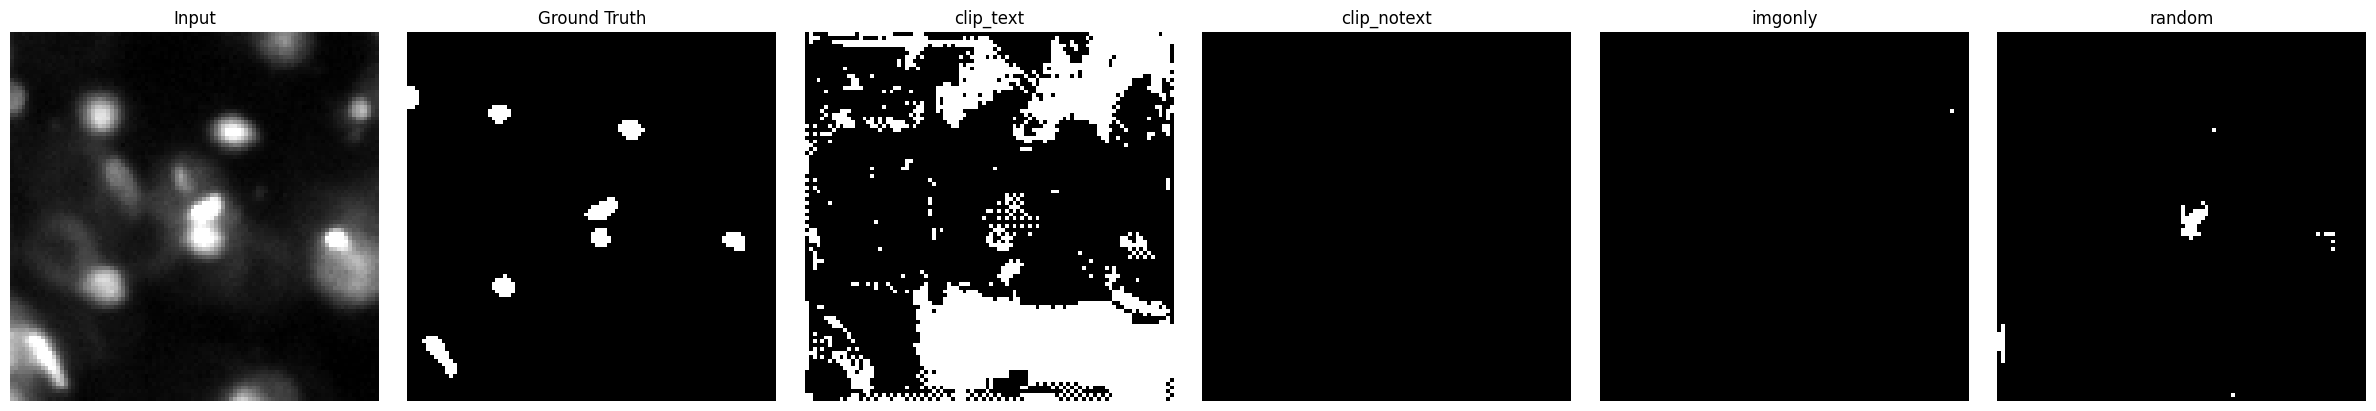

Visualizing: patch_004_vol004_ch0


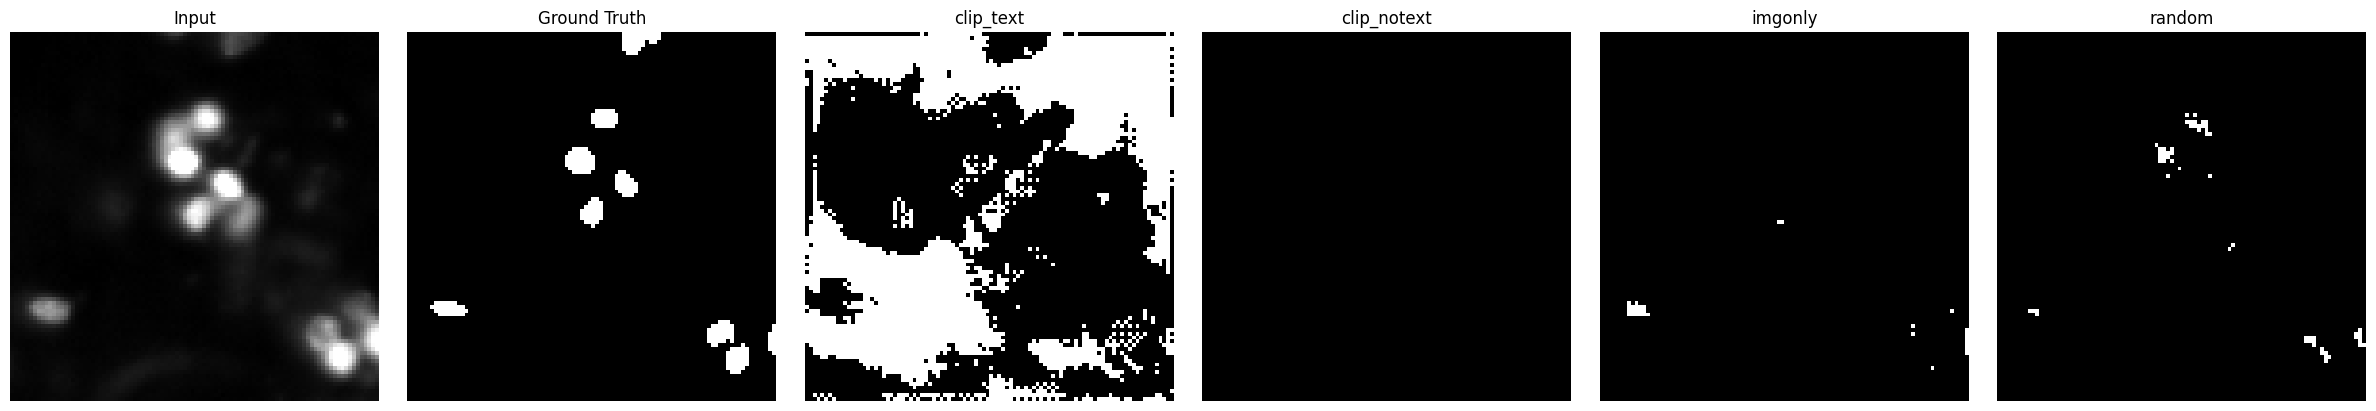


=== vessels_patches ===
Visualizing: patch_003_vol023_ch0


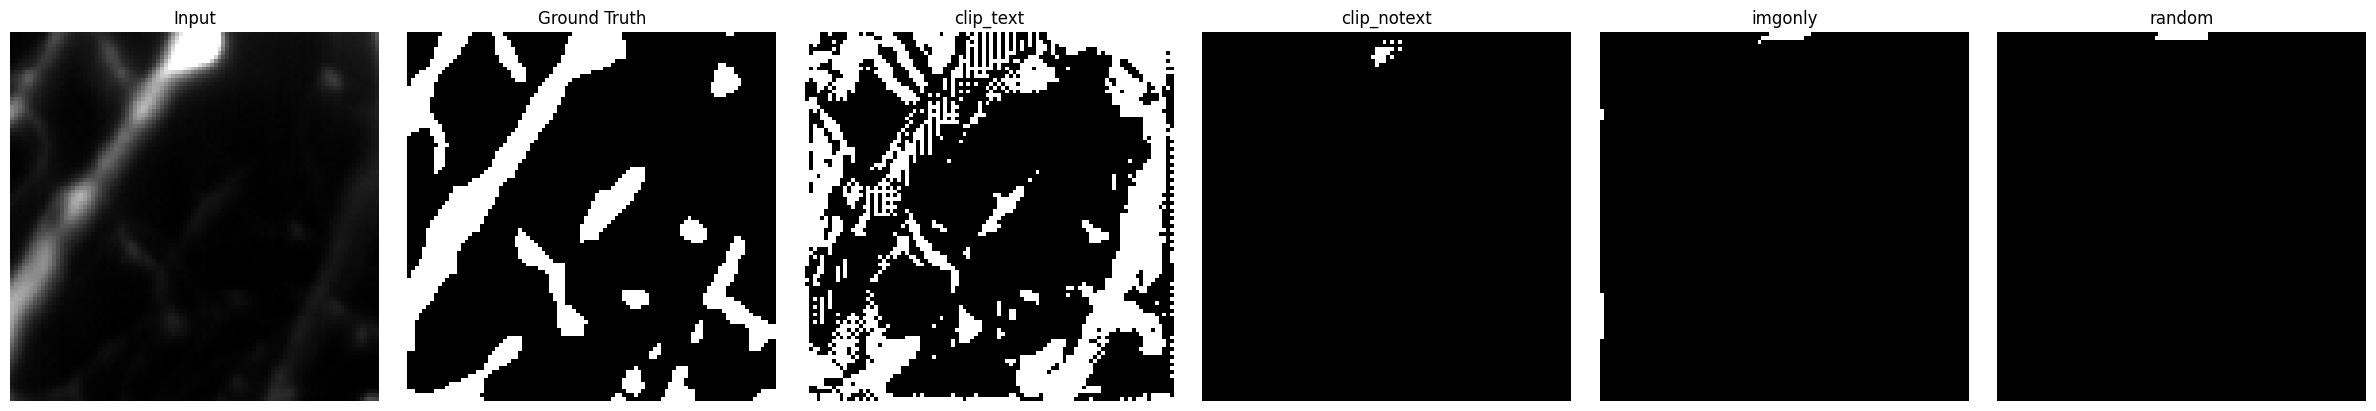

Visualizing: patch_017_vol006_ch0


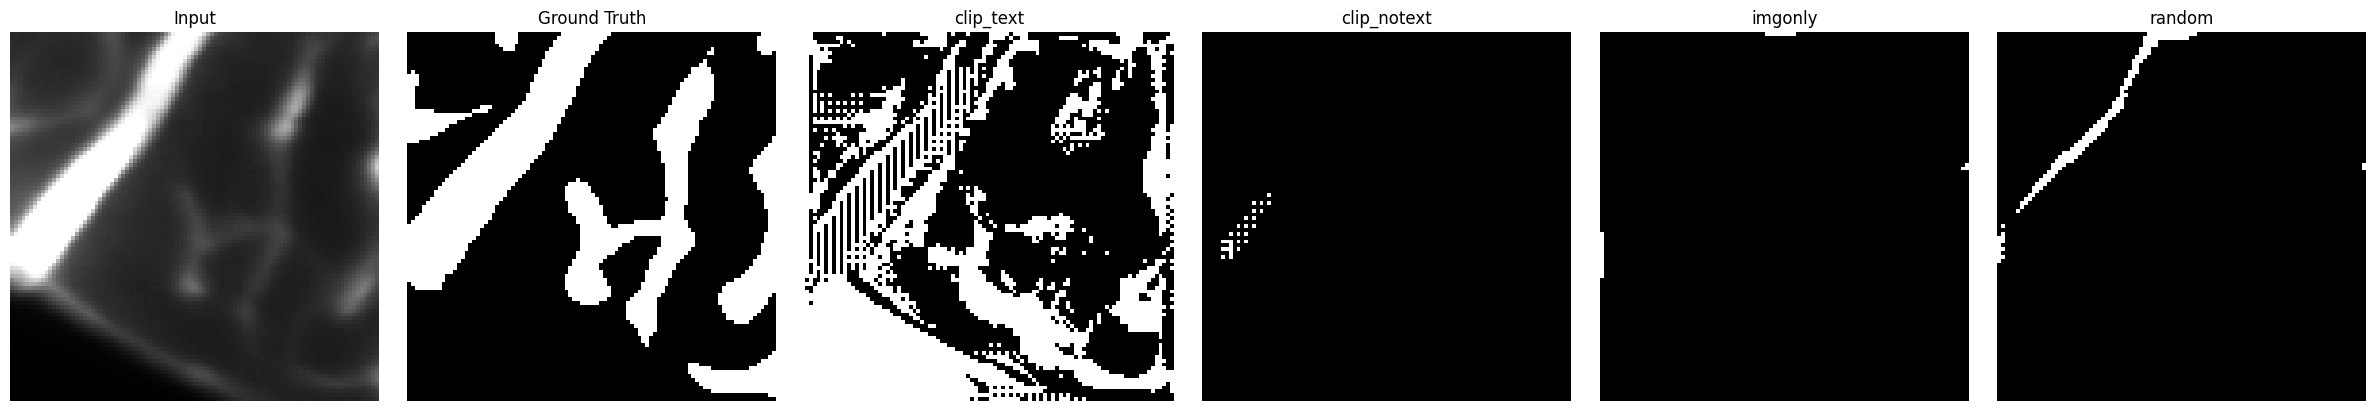

In [13]:
import random
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# ---------------------------
# CONFIG
# ---------------------------

DATA_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")
PRED_ROOT = Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot")

DATA_TYPES = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["clip_text", "clip_notext", "imgonly", "random"]

N_SAMPLES_PER_TYPE = 2
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# ---------------------------
# HELPERS
# ---------------------------

def load_nii(path):
    return nib.load(str(path)).get_fdata()

def center_slice(vol):
    z = vol.shape[-1] // 2
    return vol[..., z]

def normalize_img(x):
    lo, hi = np.percentile(x, (1, 99))
    if hi > lo:
        return np.clip((x - lo) / (hi - lo), 0, 1)
    return np.zeros_like(x)

def load_gt(img_path):
    name = img_path.name
    if name.endswith(".nii.gz"):
        base = name[:-7]  # strip ".nii.gz"
    elif name.endswith(".nii"):
        base = name[:-4]
    else:
        raise ValueError(f"Unexpected image filename: {name}")

    gt_name = f"{base}_label.nii.gz"
    gt_path = img_path.with_name(gt_name)

    if not gt_path.exists():
        print(f"[WARN] GT not found: {gt_path}")
        return None

    return load_nii(gt_path) > 0


# ---------------------------
# MAIN LOOP
# ---------------------------

for dtype in DATA_TYPES:
    print(f"\n=== {dtype} ===")

    img_dir = DATA_ROOT / dtype
    img_files = sorted(img_dir.glob("patch_*_ch0.nii.gz"))

    if len(img_files) < N_SAMPLES_PER_TYPE:
        print(f"[WARN] Not enough images in {dtype}")
        continue

    chosen_imgs = random.sample(img_files, N_SAMPLES_PER_TYPE)

    for img_path in chosen_imgs:
        base = img_path.name.replace(".nii.gz", "")
        print(f"Visualizing: {base}")

        # load input image
        img = load_nii(img_path)
        img_slice = normalize_img(center_slice(img))

        # load GT
        gt = load_gt(img_path)
        gt_slice = center_slice(gt) if gt is not None else None

        ncols = 2 + len(MODELS)
        fig, axes = plt.subplots(1, ncols, figsize=(4 * ncols, 4))

        # ---------------- Input ----------------
        axes[0].imshow(img_slice, cmap="gray")
        axes[0].set_title("Input")
        axes[0].axis("off")

        # ---------------- Ground Truth ----------------
        if gt_slice is not None:
            axes[1].imshow(gt_slice.astype(float), cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        # ---------------- Predictions ----------------
        for i, model in enumerate(MODELS, start=2):
            ax = axes[i]

            pred_path = (
                PRED_ROOT / dtype / model / "preds" / f"{base}_pred_thr0.50.nii.gz"
            )

            if not pred_path.exists():
                ax.set_title(f"{model}\n[MISSING]")
                ax.axis("off")
                continue

            pred = load_nii(pred_path)
            pred_slice = center_slice(pred)

            ax.imshow(pred_slice.astype(float), cmap="gray", vmin=0, vmax=1)
            ax.set_title(model)
            ax.axis("off")

        plt.tight_layout()
        plt.show()


In [14]:
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path

# -----------------------------
# CONFIG
# -----------------------------

PRED_ROOT = Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot")
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")

DATA_TYPES = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["clip_text", "clip_notext", "imgonly", "random"]

# -----------------------------
# HELPERS
# -----------------------------

def load_nii(path):
    return nib.load(str(path)).get_fdata()

def binarize(x):
    return x.astype(bool)

def get_gt_path(img_path):
    name = img_path.name
    base = name[:-7] if name.endswith(".nii.gz") else name[:-4]
    return img_path.with_name(f"{base}_label.nii.gz")

# -----------------------------
# METRIC LOOP
# -----------------------------

rows = []

for dtype in DATA_TYPES:
    gt_dir = GT_ROOT / dtype
    img_files = sorted(gt_dir.glob("patch_*_ch0.nii.gz"))

    for img_path in img_files:
        gt_path = get_gt_path(img_path)
        if not gt_path.exists():
            continue

        gt = binarize(load_nii(gt_path))
        gt_fg = gt.sum()
        gt_bg = gt.size - gt_fg

        for model in MODELS:
            pred_path = (
                PRED_ROOT / dtype / model / "preds" /
                img_path.name.replace(".nii.gz", "_pred_thr0.50.nii.gz")
            )

            if not pred_path.exists():
                continue

            pred = binarize(load_nii(pred_path))

            tp = np.logical_and(pred, gt).sum()
            fp = np.logical_and(pred, ~gt).sum()
            fn = np.logical_and(~pred, gt).sum()

            recall = tp / (gt_fg + 1e-8)
            precision = tp / (pred.sum() + 1e-8)
            fpr = fp / (gt_bg + 1e-8)
            vol_ratio = pred.sum() / (gt_fg + 1e-8)

            dice = (2 * tp) / (pred.sum() + gt_fg + 1e-8)

            rows.append({
                "model": model,
                "data_type": dtype,
                "recall": recall,
                "precision": precision,
                "false_positive_rate": fpr,
                "foreground_volume_ratio": vol_ratio,
                "dice": dice,
            })

metrics_df = pd.DataFrame(rows)
print("Rows:", len(metrics_df))


Rows: 272


In [15]:
summary = (
    metrics_df
    .groupby(["model", "data_type"])
    .mean()
    .reset_index()
)

display(summary.style.format({
    "recall": "{:.3f}",
    "precision": "{:.3f}",
    "false_positive_rate": "{:.3e}",
    "foreground_volume_ratio": "{:.2f}",
    "dice": "{:.3f}",
}))


,model,data_type,recall,precision,false_positive_rate,foreground_volume_ratio,dice
0,clip_notext,amyloid_plaque_patches,0.028,0.052,3.337e-02,261.24,0.012
1,clip_notext,c_fos_positive_patches,0.006,0.001,1.560e-01,9.18,0.001
2,clip_notext,cell_nucleus_patches,0.011,0.389,1.137e-02,0.37,0.019
3,clip_notext,vessels_patches,0.014,0.958,4.765e-05,0.02,0.028
4,clip_text,amyloid_plaque_patches,0.576,0.002,3.574e-01,1679.87,0.004
5,clip_text,c_fos_positive_patches,0.490,0.017,5.107e-01,32.23,0.033
6,clip_text,cell_nucleus_patches,0.477,0.032,3.731e-01,16.55,0.060
7,clip_text,vessels_patches,0.578,0.098,5.228e-01,6.52,0.165
8,imgonly,amyloid_plaque_patches,0.044,0.004,1.090e-02,62.93,0.006
9,imgonly,c_fos_positive_patches,0.050,0.035,2.728e-02,1.48,0.040


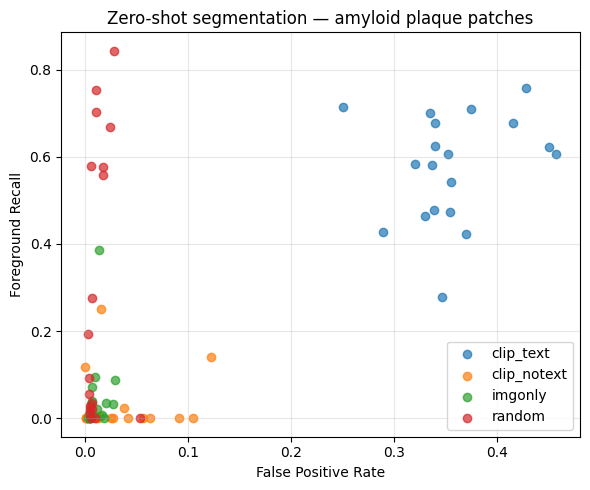

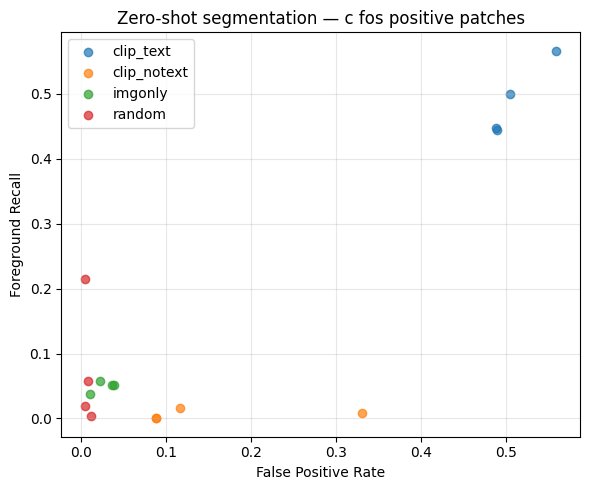

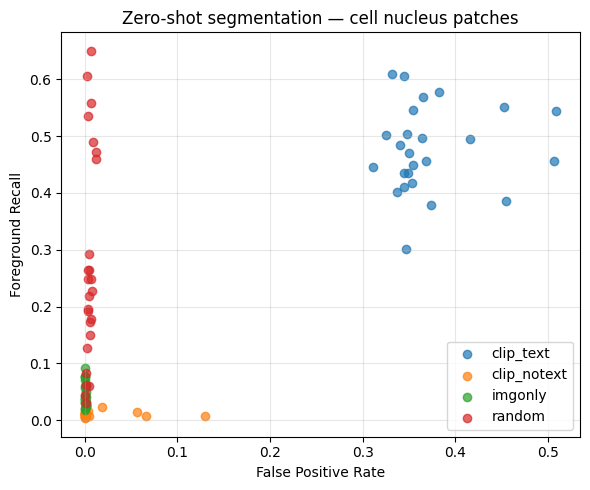

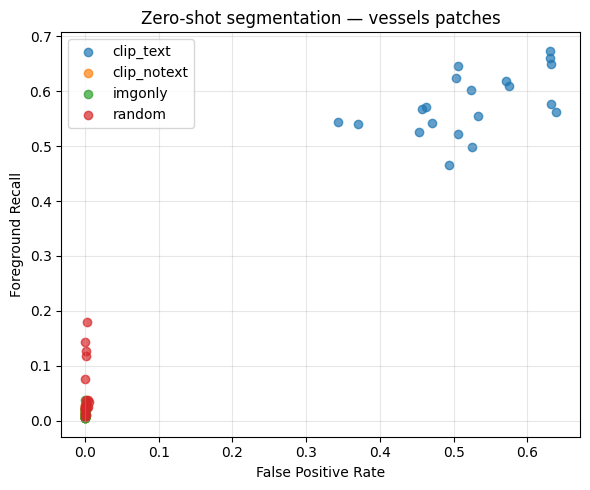

In [16]:
import matplotlib.pyplot as plt

for dtype in DATA_TYPES:
    df = metrics_df[metrics_df["data_type"] == dtype]

    plt.figure(figsize=(6, 5))
    for model in MODELS:
        d = df[df["model"] == model]
        plt.scatter(
            d["false_positive_rate"],
            d["recall"],
            label=model,
            alpha=0.7,
        )

    plt.xlabel("False Positive Rate")
    plt.ylabel("Foreground Recall")
    plt.title(f"Zero-shot segmentation — {dtype.replace('_', ' ')}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
num_cols = [
    "recall",
    "precision",
    "false_positive_rate",
    "foreground_volume_ratio",
    "dice",
]

display(
    summary.style.format({c: "{:.3f}" for c in num_cols if c in summary.columns})
)


,model,data_type,recall,precision,false_positive_rate,foreground_volume_ratio,dice
0,clip_notext,amyloid_plaque_patches,0.028,0.052,0.033,261.244,0.012
1,clip_notext,c_fos_positive_patches,0.006,0.001,0.156,9.179,0.001
2,clip_notext,cell_nucleus_patches,0.011,0.389,0.011,0.374,0.019
3,clip_notext,vessels_patches,0.014,0.958,0.000,0.015,0.028
4,clip_text,amyloid_plaque_patches,0.576,0.002,0.357,1679.872,0.004
5,clip_text,c_fos_positive_patches,0.490,0.017,0.511,32.231,0.033
6,clip_text,cell_nucleus_patches,0.477,0.032,0.373,16.551,0.060
7,clip_text,vessels_patches,0.578,0.098,0.523,6.520,0.165
8,imgonly,amyloid_plaque_patches,0.044,0.004,0.011,62.933,0.006
9,imgonly,c_fos_positive_patches,0.050,0.035,0.027,1.484,0.040


/tmp/ipykernel_3936250/2738449423.py:118: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


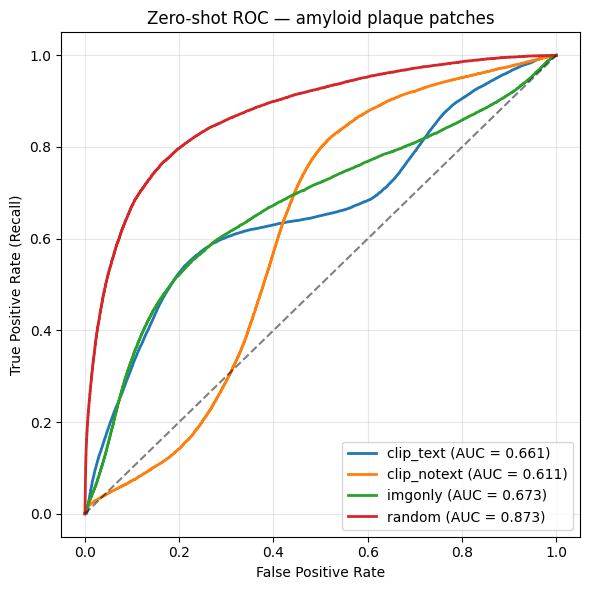

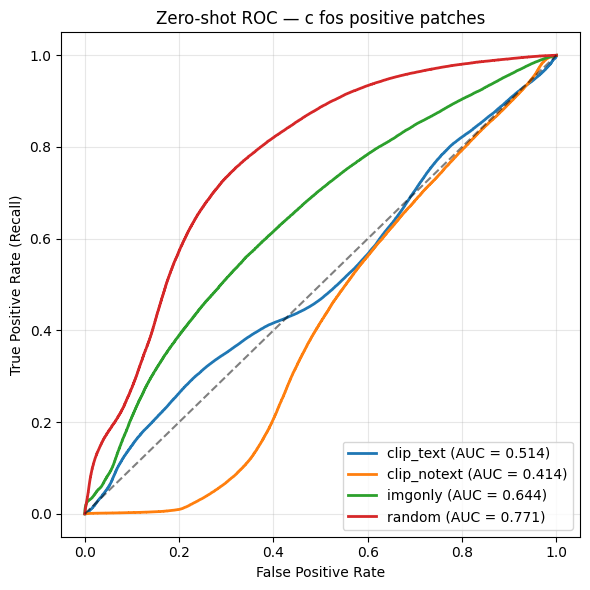

/tmp/ipykernel_3936250/2738449423.py:118: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


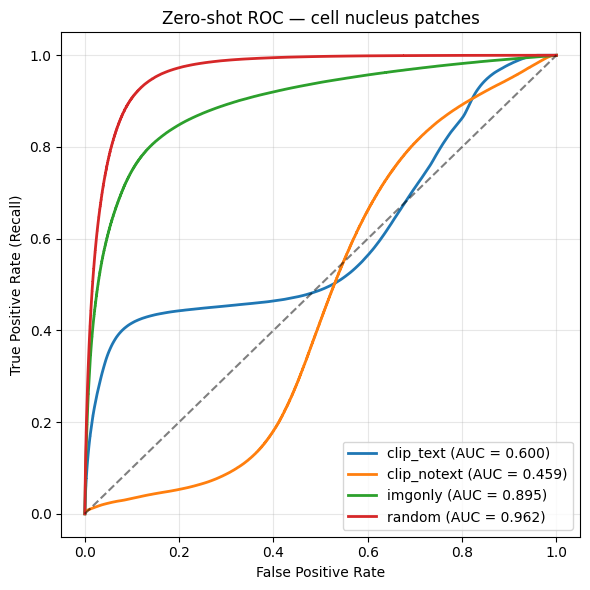

/tmp/ipykernel_3936250/2738449423.py:118: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


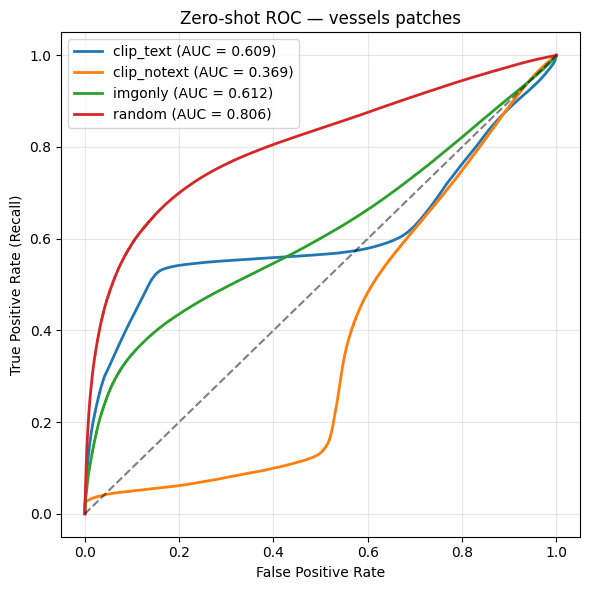

In [19]:
# ================================
# Zero-shot ROC / AUC evaluation
# ================================

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc

# ----------------------------
# PATH CONFIG
# ----------------------------

PRED_ROOT = Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot")
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")

DATA_TYPES = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["clip_text", "clip_notext", "imgonly", "random"]

MODEL_COLOR = {
    "clip_text": "tab:blue",
    "clip_notext": "tab:orange",
    "imgonly": "tab:green",
    "random": "tab:red",
}

# ----------------------------
# HELPERS
# ----------------------------

def load_nii(path):
    return nib.load(str(path)).get_fdata()

def get_gt_path(img_path):
    name = img_path.name
    if name.endswith(".nii.gz"):
        base = name[:-7]
    elif name.endswith(".nii"):
        base = name[:-4]
    else:
        raise ValueError(f"Unexpected filename: {name}")
    return img_path.with_name(f"{base}_label.nii.gz")

def compute_roc(model, dtype):
    y_true_all = []
    y_score_all = []

    gt_dir = GT_ROOT / dtype
    img_files = sorted(gt_dir.glob("patch_*_ch0.nii.gz"))

    for img_path in img_files:
        gt_path = get_gt_path(img_path)
        if not gt_path.exists():
            continue

        prob_path = (
            PRED_ROOT / dtype / model / "preds" /
            img_path.name.replace(".nii.gz", "_prob.nii.gz")
        )
        if not prob_path.exists():
            continue

        gt = load_nii(gt_path) > 0
        prob = load_nii(prob_path)

        y_true_all.append(gt.flatten())
        y_score_all.append(prob.flatten())

    if len(y_true_all) == 0:
        return None

    y_true = np.concatenate(y_true_all)
    y_score = np.concatenate(y_score_all)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

# ----------------------------
# ROC PLOTTING
# ----------------------------

for dtype in DATA_TYPES:
    plt.figure(figsize=(6, 6))

    for model in MODELS:
        result = compute_roc(model, dtype)
        if result is None:
            print(f"[WARN] No data for {model} on {dtype}")
            continue

        fpr, tpr, roc_auc = result

        plt.plot(
            fpr,
            tpr,
            color=MODEL_COLOR[model],
            linewidth=2,
            label=f"{model} (AUC = {roc_auc:.3f})"
        )

    # random baseline
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"Zero-shot ROC — {dtype.replace('_', ' ')}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
